# **Aplicación Pruning de Modelo MobileNetV3-Large**
El presente notebook fue desarrollado con el objetivo de aplicar la técnica de poda (pruning) optimización de modelos de aprendizaje profundo sobre la arquitectura ´MobileNetV3-Large´, previamente entrenada mediante aprendizaje supervisado para la detección y clasificación de enfermedades foliares en cultivos de maíz —específicamente roya común, mancha gris y tizón foliar—, así como para la identificación de hojas sanas.

El propósito principal de este script es optimizar el modelo para su despliegue en entornos de borde (edge devices), mediante la aplicación progresiva de poda (pruning) y cuantización (quantization), evaluando en cada etapa las métricas de rendimiento con el fin de reducir el tamaño y el consumo computacional del modelo sin comprometer significativamente su confiabilidad ni precisión.

In [ ]:
# Esta instalación solo es necesaria si se ejecuta este Notebook fuera de Google Colab
#!pip install tensorflow-model-optimization -q

In [ ]:
# ==========================================
# IMPORTE DE LIBRERIAS
# ==========================================

import tensorflow as tf
#import tensorflow_model_optimization as tfmot
import numpy as np
import os, time, gzip, pickle, json, statistics
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from pathlib import Path
#import tensorflow.lite as tflite # Import tflite here

## **Configuración del Entorno**
En esta sección se establece la configuración inicial del entorno de ejecución y los parámetros globales requeridos para aplicar las técnicas de poda y cuantización sobre el modelo `MobileNetV3-Large`.

Se define un diccionario `CONFIG` que contiene las rutas y parámetros clave del proceso:



*   **DATA_DIR:**
      ruta base donde se almacenan los datos y recursos del proyecto.
*   **IMG_SIZE:**
      tamaño de las imágenes de entrada al modelo, definido como (224 × 224) píxeles, compatible con la arquitectura MobileNetV3.
*   **BATCH_SIZE:**
      tamaño del lote utilizado durante las evaluaciones o conversiones, en este caso, 64 imágenes por lote.
*   **MODEL_PATH:**
      ruta del modelo previamente entrenado que será optimizado mediante poda y cuantización.

Además, se realiza una verificación automática de la disponibilidad de GPU utilizando tf.config.list_physical_devices('GPU'). Si una GPU está disponible, se habilita el crecimiento dinámico de memoria (set_memory_growth), lo que permite un uso más eficiente de los recursos durante las operaciones de TensorFlow.

In [ ]:
# ==================
#  1. CONFIGURACIÓN
# ==================
print("Configurando entorno...")

# Configuración
CONFIG = {
    "DATA_DIR": "/content/drive/MyDrive/data",
    "IMG_SIZE": (224, 224),
    "BATCH_SIZE": 64,
    "MODEL_PATH": "/content/drive/MyDrive/modelo_final_mejorado.keras"
}

# Verificar GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU disponible: {gpus[0].name}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Configurando entorno...
GPU disponible: /physical_device:GPU:0


## **Carga de Dataset y Modelo Original**
En esta sección se realiza la importación del conjunto de datos y la carga del modelo base que servirá como punto de partida para la aplicación de las técnica de poda.

Primero, se establece la conexión con Google Drive mediante la instrucción drive.mount('/content/drive'), lo que permite acceder a los archivos almacenados en la nube desde el entorno de ejecución de Google Colab.

A continuación, se carga el conjunto de datos de prueba utilizando la función `image_dataset_from_directory`, la cual permite generar un dataset de TensorFlow directamente desde un directorio estructurado en carpetas por clase.
El dataset se configura con los siguientes parámetros definidos anteriormente en `CONFIG`:



*   **image_size:**
      tamaño de las imágenes de entrada (224 × 224 píxeles).
*   **batch_size:**
      tamaño del lote (64).
*   **shuffle:**
      desactivado (False) para mantener el orden y facilitar la comparación con las predicciones.
*   **label_mode:**
      modo de etiquetas entero ('int'), compatible con clasificación categórica.

Después, se optimiza el pipeline de entrada mediante la directiva prefetch(AUTOTUNE), que permite precargar datos en memoria para acelerar el proceso de inferencia y evaluación.

Finalmente, se carga el modelo original entrenado desde la ruta especificada en MODEL_PATH usando tf.keras.models.load_model(). Este modelo constituye la base sobre la cual se aplicarán las técnicas de poda estructural.

In [ ]:
# ==========================================
# 2. CARGAR DATOS Y MODELO ORIGINAL
# ==========================================
from google.colab import drive

# conectar con drive
drive.mount('/content/drive')

print("\nCargando datos y modelo original...")

# Cargar datasets
test_ds_original = image_dataset_from_directory(
    os.path.join(CONFIG["DATA_DIR"], "test"),
    image_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False,
    label_mode='int'
)

class_names = test_ds_original.class_names
print(f"Clases: {class_names}")

# Optimizar dataset
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds_original.prefetch(AUTOTUNE)

# Cargar modelo original
print("Cargando modelo original...")
original_model = tf.keras.models.load_model(CONFIG["MODEL_PATH"])
print("Modelo original cargado exitosamente")

Mounted at /content/drive

Cargando datos y modelo original...
Found 1488 files belonging to 4 classes.
Clases: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
Cargando modelo original...
Modelo original cargado exitosamente


## **Evaluación del Modelo Base**
En esta sección se realiza la evaluación integral del modelo base `MobileNetV3-Large` previamente cargado, con el objetivo de establecer una línea base de rendimiento frente a la cual se compararán los resultados obtenidos después de aplicar la poda.

Para ello, se define la función evaluate_model_comprehensive(), que ejecuta un proceso de evaluación detallado compuesto por cinco etapas principales:



1.   **Evaluación básica:**
      Se calcula la accuracy del modelo sobre el conjunto de datos de prueba mediante el método model.evaluate(). Este valor constituye la métrica principal de referencia.
2.   **Estimación del tamaño del modelo:**
      El modelo se guarda temporalmente en formato .keras y se calcula su tamaño en megabytes (MB) utilizando os.path.getsize(). Esto permite cuantificar el impacto que tendrán posteriormente las técnicas de reducción.
3.    **Medición del tiempo de inferencia:**
      Se mide el tiempo promedio que tarda el modelo en procesar una imagen (avg_inference_time_ms) usando el módulo time. Esta métrica es clave para evaluar la eficiencia del modelo en escenarios de despliegue en el borde (edge computing).
4.    **Cálculo de métricas de clasificación:**
      A partir de las predicciones generadas, se calculan métricas avanzadas de desempeño —precisión, recuperación (recall) y F1-score— mediante la función precision_recall_fscore_support de scikit-learn, utilizando un promedio ponderado (weighted).
5.    **Generación de la matriz de confusión:**
      Se construye una matriz de confusión (confusion_matrix) que permite analizar el comportamiento del modelo frente a cada clase individual (roya común, mancha gris, tizón foliar y planta sana).

Finalmente, la función retorna un diccionario con todas las métricas calculadas, lo que facilita su comparación con los resultados de las versiones optimizadas.
El bloque concluye imprimiendo el accuracy y el tamaño del modelo original, que servirán como valores de referencia base para el análisis posterior de eficiencia y rendimiento.

In [ ]:
# ==========================================
# 3. EVALUACIÓN DEL MODELO ORIGINAL
# ==========================================

def evaluate_model_comprehensive(model, dataset, model_name="Modelo"):
    print(f"\nEVALUANDO {model_name}...")

    # 1. Evaluación básica
    print("Calculando accuracy...Este Proceso Puede Tardar Varios Minutos...")
    try:
        test_loss, test_accuracy = model.evaluate(dataset, verbose=0)
        print(f"Accuracy: {test_accuracy:.4f}")
    except Exception as e:
        print(f"Error en evaluación: {e}")
        return None

    # 2. Tamaño del modelo
    print("Calculando tamaño del modelo...")
    model_size_mb = 0
    try:
        temp_path = f"/content/temp_{model_name.replace(' ', '_')}.keras"
        model.save(temp_path)
        model_size_mb = os.path.getsize(temp_path) / (1024 * 1024)
        os.remove(temp_path)
        print(f"Tamaño Keras: {model_size_mb:.2f} MB")
    except Exception as e:
        print(f"Error calculando tamaño: {e}")
        return None

    # 3. Tiempo de inferencia y predicciones
    print("Midiendo tiempo de inferencia...")
    all_preds = []
    all_labels = []
    inference_times = []

    for images, labels in dataset:
        batch_start = time.time()
        preds = model.predict(images, verbose=0)
        batch_time = time.time() - batch_start
        inference_times.append(batch_time / len(images))

        pred_classes = np.argmax(preds, axis=1)
        all_preds.extend(pred_classes)
        all_labels.extend(labels.numpy())

    avg_inference_time = np.mean(inference_times) * 1000

    # 4. Métricas de clasificación
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # 5. Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Resumen {model_name}:")
    print(f"Tiempo inferencia: {avg_inference_time:.2f} ms")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return {
        'accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'model_size_mb': model_size_mb,
        'avg_inference_time_ms': avg_inference_time,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels
    }

# Evaluar modelo original
original_metrics = evaluate_model_comprehensive(original_model, test_ds, "MODELO ORIGINAL")

print(f"Modelo Original - Accuracy: {original_metrics['accuracy']:.4f}, Tamaño: {original_metrics['model_size_mb']:.2f} MB")


EVALUANDO MODELO ORIGINAL...
Calculando accuracy...Este Proceso Puede Tardar Varios Minutos...
Accuracy: 0.9234
Calculando tamaño del modelo...
Tamaño Keras: 40.78 MB
Midiendo tiempo de inferencia...
Resumen MODELO ORIGINAL:
Tiempo inferencia: 29.41 ms
Precision: 0.9228, Recall: 0.9234, F1: 0.9231
Modelo Original - Accuracy: 0.9234, Tamaño: 40.78 MB


## **Pruning Post-Entrenamiento**
En esta sección se implementa la técnica de poda (pruning) al modelo entrenado y cargado anteriormente con el objetivo de reducir la complejidad del mismo y eliminar pesos redundantes, manteniendo al mismo tiempo un rendimiento predictivo aceptable. Esta estrategia permite optimizar el modelo para su despliegue en entornos con recursos limitados, como dispositivos embebidos o de borde (edge devices).

El procedimiento se realiza mediante la función apply_post_training_pruning(), que ejecuta los siguientes pasos:

1. **Clonación del modelo original:**
      Se crea una copia exacta del modelo entrenado usando tf.keras.models.clone_model() para preservar la arquitectura y los pesos originales, evitando modificaciones irreversibles sobre el modelo base.

2. **Aplicación del pruning capa a capa:**
      La poda se aplica exclusivamente sobre las capas densas (Dense) del modelo. Para cada capa:

    *   Se obtiene el kernel de pesos.
    *   Se calcula un umbral (threshold) correspondiente al percentil definido por el parámetro target_sparsity (por defecto, 50%).
    *   Se genera una máscara binaria que conserva únicamente los pesos con magnitud superior al umbral.
    *   Los pesos restantes se eliminan (se establecen en cero), generando una estructura más esparsa.

3. **Cálculo de la esparsidad:**
      Tras el proceso de poda, se calcula y muestra el porcentaje de esparsidad alcanzado por capa, lo que permite verificar el nivel de reducción estructural logrado.

4. **Compilación del modelo pruneado:**
      El modelo resultante se recompila con el optimizador Adam y la función de pérdida Sparse Categorical Crossentropy para permitir su posterior evaluación y comparación con el modelo original.

El resultado final es un modelo con pesos reducidos y estructura más ligera, lo que se traduce en menor carga computacional y potencial mejora en la velocidad de inferencia, a costa de una posible disminución leve en la precisión.

In [ ]:
# ==========================================
# 4. PRUNING POST-ENTRENAMIENTO
# ==========================================
print("\nAPLICANDO PRUNING POST-ENTRENAMIENTO...")

def apply_post_training_pruning(model, target_sparsity=0.5):
    """
    Aplica pruning directamente a los pesos del modelo ya entrenado
    """
    print(f"Aplicando pruning post-entrenamiento con {target_sparsity*100}% de esparsidad...")

    # Crear una copia del modelo
    pruned_model = tf.keras.models.clone_model(model)
    pruned_model.set_weights(model.get_weights())

    # Aplicar pruning a los pesos
    for layer in pruned_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()
            if len(weights) > 0:
                # Aplicar pruning a los pesos (kernel)
                kernel = weights[0]
                threshold = np.percentile(np.abs(kernel), target_sparsity * 100)
                mask = np.abs(kernel) > threshold
                pruned_kernel = kernel * mask

                # Actualizar pesos
                if len(weights) > 1:
                    # Si hay bias, mantenerlo
                    layer.set_weights([pruned_kernel, weights[1]])
                else:
                    layer.set_weights([pruned_kernel])

                # Calcular esparsidad de esta capa
                sparsity = np.sum(mask == 0) / mask.size
                print(f"   {layer.name}: {sparsity*100:.1f}% esparsa")

    return pruned_model

# Aplicar pruning post-entrenamiento
print("Aplicando pruning directo a los pesos...")
pruned_model = apply_post_training_pruning(original_model, target_sparsity=0.5)

# Compilar el modelo pruneado
pruned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Pruning post-entrenamiento aplicado exitosamente")


APLICANDO PRUNING POST-ENTRENAMIENTO...
Aplicando pruning directo a los pesos...
Aplicando pruning post-entrenamiento con 50.0% de esparsidad...
   dense: 50.0% esparsa
   dense_1: 50.0% esparsa
   dense_2: 50.0% esparsa
Pruning post-entrenamiento aplicado exitosamente


### **EVALUACIÓN MODELO PRUNEADO**
A continuación realizamos una revisión de las métricas más relevantes del modelo con el fin de hacer seguimiento previo a continuar el proceso de optimización

In [ ]:
# ==========================================
# 5. EVALUACIÓN MODELO PRUNEADO
# ==========================================
pruned_metrics = evaluate_model_comprehensive(pruned_model, test_ds, "MODELO PRUNEADO")



EVALUANDO MODELO PRUNEADO...
Calculando accuracy...Este Proceso Puede Tardar Varios Minutos...
Accuracy: 0.9207
Calculando tamaño del modelo...
Tamaño Keras: 14.49 MB
Midiendo tiempo de inferencia...
Resumen MODELO PRUNEADO:
Tiempo inferencia: 22.81 ms
Precision: 0.9205, Recall: 0.9207, F1: 0.9206


## **Análisis de Esparsidad**

En esta sección se evalúa la efectividad del proceso de poda analizando la proporción de pesos que fueron eliminados (es decir, establecidos en cero) dentro de las capas densas del modelo.

El análisis se realiza capa por capa, contabilizando el número total de elementos y los que tienen valor cero. A partir de esta información, se calcula la “esparsidad” individual de cada capa y la esparsidad total del modelo, expresada como un porcentaje.

Un valor alto de esparsidad (por ejemplo, >50%) indica que una gran cantidad de pesos han sido descartados, lo que potencialmente reduce la complejidad computacional del modelo durante la inferencia, aunque no necesariamente su tamaño físico en disco.


In [ ]:
# ==========================================
# 6. ANÁLISIS DE ESPARSIDAD
# ==========================================
print("\nANALIZANDO ESPARSIDAD DEL MODELO PRUNEADO...")

def analyze_model_sparsity(model):
    print("Análisis de Esparsidad por Capa:")
    total_zeros = 0
    total_elements = 0

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()
            if len(weights) > 0:
                layer_zeros = 0
                layer_elements = 0
                for weight in weights:
                    zeros = np.sum(weight == 0)
                    elements = weight.size
                    layer_zeros += zeros
                    layer_elements += elements

                if layer_elements > 0:
                    sparsity = layer_zeros / layer_elements * 100
                    print(f"   {layer.name}: {sparsity:.1f}% esparsa")
                    total_zeros += layer_zeros
                    total_elements += layer_elements

    if total_elements > 0:
        total_sparsity = total_zeros / total_elements * 100
        print(f"Esparsidad total del modelo: {total_sparsity:.1f}%")
        return total_sparsity
    return 0

total_sparsity = analyze_model_sparsity(pruned_model)


ANALIZANDO ESPARSIDAD DEL MODELO PRUNEADO...
Análisis de Esparsidad por Capa:
   dense: 49.9% esparsa
   dense_1: 49.9% esparsa
   dense_2: 49.8% esparsa
Esparsidad total del modelo: 49.9%


In [ ]:
# ==========================================
#  7. GUARDAR
# ==========================================


# Guardar modelo pruneado

do_fine_tuning = input("¿Deseas guardar el modelo pruneado? (s/n): ").lower().strip()

if do_fine_tuning == 's':

  print("\nGUARDANDO MODELO OPTIMIZADO...")

  pruned_keras_path = "/content/modelo_pruneado.keras"
  pruned_model.save(pruned_keras_path)

  print(f"\nARCHIVO GENERADO:")
  print(f"- Modelo pruneado Keras: {pruned_keras_path}")

  print(f"\n¡PROCESO COMPLETADO!")

else:
  print("Saltando fine-tuning...")

¿Deseas guardar el modelo pruneado? (s/n): s

GUARDANDO MODELO OPTIMIZADO...

ARCHIVO GENERADO:
- Modelo pruneado Keras: /content/modelo_pruneado.keras

¡PROCESO COMPLETADO!


## **Fine-Tuning Modelo Pruneado**
En esta sección se ofrece la posibilidad de realizar un proceso de fine-tuning
(ajuste fino) sobre el modelo después de aplicar la poda. Esta etapa tiene como
objetivo recuperar parte de la precisión que pudo haberse perdido durante el
pruning, reajustando los pesos restantes del modelo.

Para ello, se cargan nuevamente los conjuntos de entrenamiento y validación,
y se ejecuta un entrenamiento corto (por defecto, 2 épocas y un subconjunto de batches) con early stopping para evitar sobreajuste.

Si el usuario elige no realizar esta fase, el script continúa directamente
con la evaluación final del modelo pruneado sin reajuste adicional.


In [ ]:
# ==========================================
# 8. FINE-TUNING DEL MODELO PRUNEADO
# ==========================================
print("\nFINE-TUNING DEL MODELO PRUNEADO...")

# Cargar datos de entrenamiento para fine-tuning
train_ds = image_dataset_from_directory(
    os.path.join(CONFIG["DATA_DIR"], "train"),
    image_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    label_mode='int'
).prefetch(AUTOTUNE)

val_ds = image_dataset_from_directory(
    os.path.join(CONFIG["DATA_DIR"], "val"),
    image_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    label_mode='int'
).prefetch(AUTOTUNE)

# Realizando Fine-Tuning
print("Realizando fine-tuning (2 épocas)...")

#  Callback para early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=0
    )
]

# Fine-tuning corto
history = pruned_model.fit(
    train_ds.take(30),  # Solo 30 batches para fine-tuning rápido
    epochs=2,
    validation_data=val_ds.take(10),
    callbacks=callbacks,
    verbose=0
)

# Re-evaluar después del fine-tuning
print("\nRe-evaluando después del fine-tuning...")
pruned_ft_metrics = evaluate_model_comprehensive(pruned_model, test_ds, "MODELO PRUNEADO (fine-tuned)")



FINE-TUNING DEL MODELO PRUNEADO...
Found 6955 files belonging to 4 classes.
Found 1488 files belonging to 4 classes.
Realizando fine-tuning (2 épocas)...

Re-evaluando después del fine-tuning...

EVALUANDO MODELO PRUNEADO (fine-tuned)...
Calculando accuracy...Este Proceso Puede Tardar Varios Minutos...
Accuracy: 0.8884
Calculando tamaño del modelo...
Tamaño Keras: 40.78 MB
Midiendo tiempo de inferencia...
Resumen MODELO PRUNEADO (fine-tuned):
Tiempo inferencia: 4.19 ms
Precision: 0.8898, Recall: 0.8884, F1: 0.8882


## **Revisión y Resultados**

A continuación se imprime dos comparativas de rendimiento del modelo: Original vs Pruneado y Original vs Pruneado + Fine-Tuning. Para cada caso calcula la reducción de tamaño (MB) y la mejora en tiempo de inferencia (ms) como porcentajes, y la variación de accuracy respecto al original.

In [ ]:
# ==========================================
# 9. COMPARACIÓN COMPLETA Y RESULTADOS
# ==========================================
print("\n" + "="*60)
print("COMPARACIÓN PRUNING: ORIGINAL vs PRUNEADO")
print("="*60)

# Calcular métricas de comparación
size_reduction = (1 - pruned_metrics['model_size_mb'] / original_metrics['model_size_mb']) * 100
speed_improvement = (1 - pruned_metrics['avg_inference_time_ms'] / original_metrics['avg_inference_time_ms']) * 100
accuracy_change = pruned_metrics['accuracy'] - original_metrics['accuracy']

# Crear tabla comparativa
comparison_data = {
    'Métrica': [
        'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Tamaño (MB)',
        'Tiempo Inferencia (ms)', 'Esparsidad'
    ],
    'Original': [
        f"{original_metrics['accuracy']:.4f}",
        f"{original_metrics['precision']:.4f}",
        f"{original_metrics['recall']:.4f}",
        f"{original_metrics['f1_score']:.4f}",
        f"{original_metrics['model_size_mb']:.2f}",
        f"{original_metrics['avg_inference_time_ms']:.2f}",
        "0%"
    ],
    'Pruneado': [
        f"{pruned_metrics['accuracy']:.4f}",
        f"{pruned_metrics['precision']:.4f}",
        f"{pruned_metrics['recall']:.4f}",
        f"{pruned_metrics['f1_score']:.4f}",
        f"{pruned_metrics['model_size_mb']:.2f}",
        f"{pruned_metrics['avg_inference_time_ms']:.2f}",
        f"{total_sparsity:.1f}%"
    ],
    'Diferencia': [
        f"{accuracy_change:+.4f}",
        f"{pruned_metrics['precision'] - original_metrics['precision']:+.4f}",
        f"{pruned_metrics['recall'] - original_metrics['recall']:+.4f}",
        f"{pruned_metrics['f1_score'] - original_metrics['f1_score']:+.4f}",
        f"-{size_reduction:.1f}%",
        f"+{speed_improvement:.1f}%",
        f"+{total_sparsity:.1f}%"
    ]
}
# Mostrar tabla
import pandas as pd
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

#=================================
#  Modelo Pruneado + Fine-Tuning
#=================================

print("\n" + "="*60)
print("COMPARACIÓN ORIGINAL vs (PRUNEADO + FINE-TUNING)")
print("="*60)

# Calcular métricas de comparación
size_reduction_ft = (1 - pruned_ft_metrics['model_size_mb'] / original_metrics['model_size_mb']) * 100
speed_improvement_ft = (1 - pruned_ft_metrics['avg_inference_time_ms'] / original_metrics['avg_inference_time_ms']) * 100
accuracy_change_ft = pruned_ft_metrics['accuracy'] - original_metrics['accuracy']

# Crear tabla comparativa
comparison_data_ft = {
    'Métrica': [
        'Accuracy', 'Precision', 'Recall', 'F1-Score',
        'Tamaño (MB)',
        'Tiempo Inferencia (ms)', 'Esparsidad'
    ],
    'Original': [
        f"{original_metrics['accuracy']:.4f}",
        f"{original_metrics['precision']:.4f}",
        f"{original_metrics['recall']:.4f}",
        f"{original_metrics['f1_score']:.4f}",
        f"{original_metrics['model_size_mb']:.2f}",
        f"{original_metrics['avg_inference_time_ms']:.2f}",
        "0%"
    ],
    'Pruneado_FT': [
        f"{pruned_ft_metrics['accuracy']:.4f}",
        f"{pruned_ft_metrics['precision']:.4f}",
        f"{pruned_ft_metrics['recall']:.4f}",
        f"{pruned_ft_metrics['f1_score']:.4f}",
        f"{pruned_ft_metrics['model_size_mb']:.2f}",
        f"{pruned_ft_metrics['avg_inference_time_ms']:.2f}",
        f"{total_sparsity:.1f}%"
    ],
    ' Diferencia': [
        f"{accuracy_change_ft:+.4f}",
        f"{pruned_ft_metrics['precision'] - original_metrics['precision']:+.4f}",
        f"{pruned_ft_metrics['recall'] - original_metrics['recall']:+.4f}",
        f"{pruned_ft_metrics['f1_score'] - original_metrics['f1_score']:+.4f}",
        f"-{size_reduction_ft:.1f}%",
        f"+{speed_improvement_ft:.1f}%",
        f"+{total_sparsity:.1f}%"
    ]
}

# Mostrar tabla
import pandas as pd
df_comparison_ft = pd.DataFrame(comparison_data_ft)
print(df_comparison_ft.to_string(index=False))



COMPARACIÓN PRUNING: ORIGINAL vs PRUNEADO
               Métrica Original Pruneado Diferencia
              Accuracy   0.9234   0.9207    -0.0027
             Precision   0.9228   0.9205    -0.0022
                Recall   0.9234   0.9207    -0.0027
              F1-Score   0.9231   0.9206    -0.0025
           Tamaño (MB)    40.78    14.49     -64.5%
Tiempo Inferencia (ms)    29.41    22.81     +22.5%
            Esparsidad       0%    49.9%     +49.9%

COMPARACIÓN ORIGINAL vs (PRUNEADO + FINE-TUNING)
               Métrica Original Pruneado_FT  Diferencia
              Accuracy   0.9234      0.8884     -0.0349
             Precision   0.9228      0.8898     -0.0330
                Recall   0.9234      0.8884     -0.0349
              F1-Score   0.9231      0.8882     -0.0348
           Tamaño (MB)    40.78       40.78       -0.0%
Tiempo Inferencia (ms)    29.41        4.19      +85.8%
            Esparsidad       0%       49.9%      +49.9%


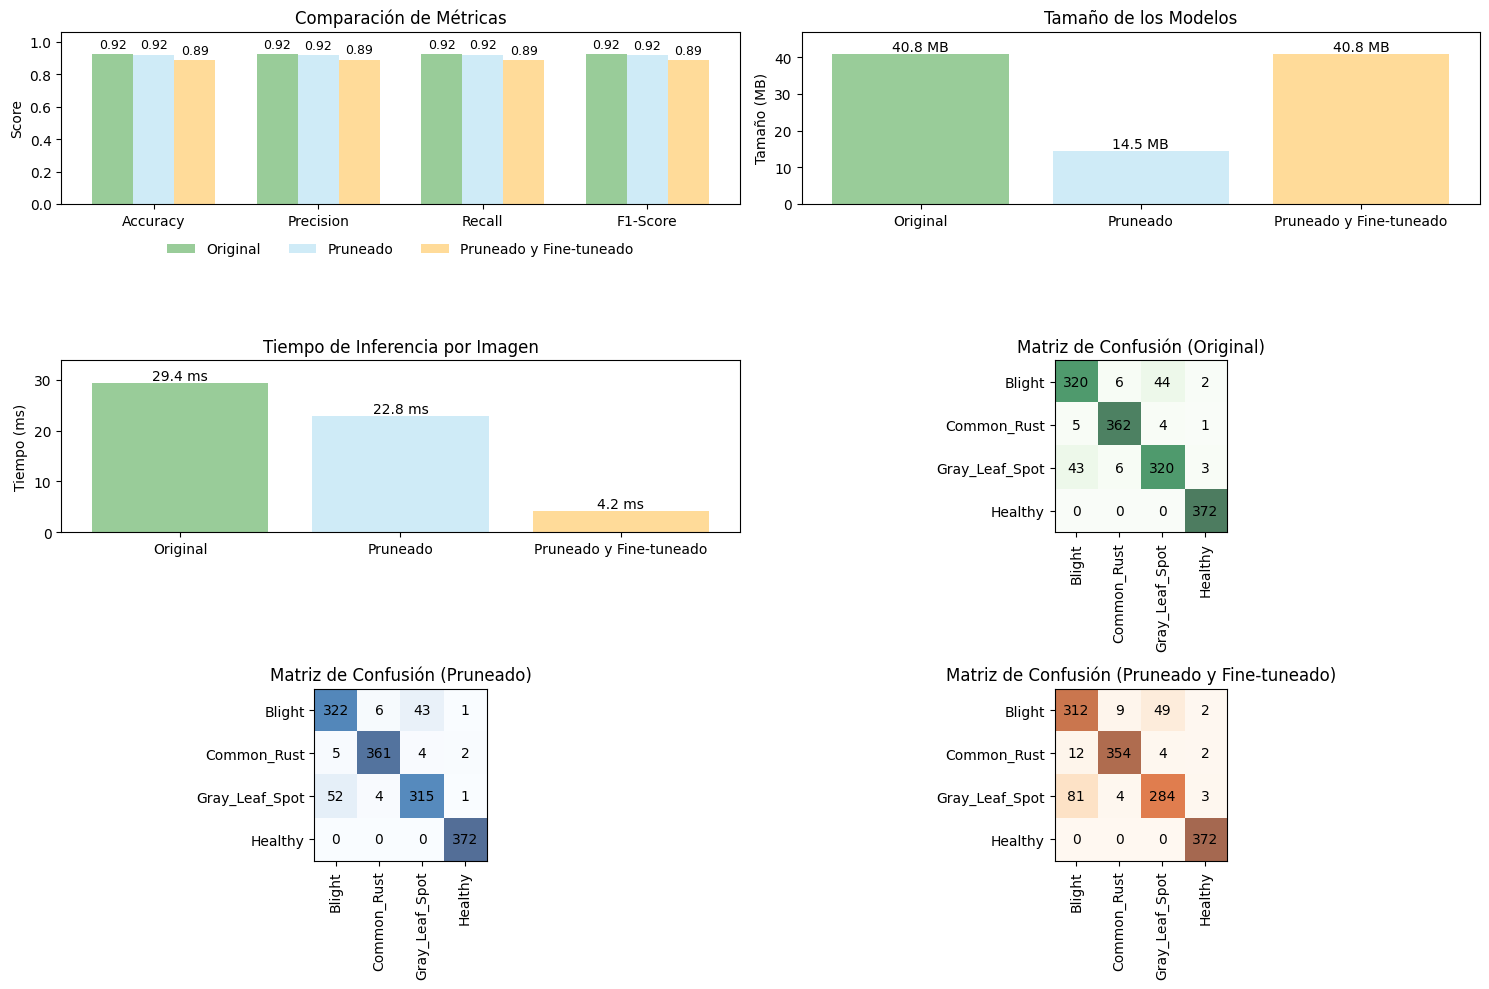

In [ ]:
# ==========================================
# 10. GRÁFICAS COMPARATIVAS
# ==========================================

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Gráfica 1: Métricas de accuracy
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_original = [
    original_metrics['accuracy'],
    original_metrics['precision'],
    original_metrics['recall'],
    original_metrics['f1_score']
]
metrics_pruned = [
    pruned_metrics['accuracy'],
    pruned_metrics['precision'],
    pruned_metrics['recall'],
    pruned_metrics['f1_score']
]
metrics_pruned_ft = [
    pruned_ft_metrics['accuracy'],
    pruned_ft_metrics['precision'],
    pruned_ft_metrics['recall'],
    pruned_ft_metrics['f1_score']
]
x_pos = np.arange(len(metrics_names))
width = 0.25

bar1 = axes[0, 0].bar(x_pos - width, metrics_original, width, label='Original', alpha=0.4, color='green')
bar2 = axes[0, 0].bar(x_pos , metrics_pruned, width, label='Pruneado', alpha=0.4, color='skyblue')
bar3 = axes[0, 0].bar(x_pos + width, metrics_pruned_ft, width, label='Pruneado y Fine-tuneado', alpha=0.4, color='orange')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparación de Métricas')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(metrics_names, rotation=0)
axes[0, 0].legend()

max_size = max(max(metrics_original),max(metrics_pruned),max(metrics_pruned_ft))
axes[0, 0].set_ylim(0, max_size * 1.15)

# Añadir etiquetas sobre cada barra

for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(
            bar.get_x() + bar.get_width() / 2,  # posición centrada en X
            height + 0.02,                      # ligeramente arriba de la barra
            f"{height:.2f}",                    # valor con dos decimales
            ha='center', va='bottom', fontsize=9, color='black'
        )

axes[0, 0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # debajo de la gráfica
    ncol=3,
    frameon=False
)

# Gráfica 2: Tamaños de modelo

sizes_tflite = [original_metrics['model_size_mb'], pruned_metrics['model_size_mb'], pruned_ft_metrics['model_size_mb']]
labels = ['Original', 'Pruneado','Pruneado y Fine-tuneado']
colors = ['green', 'skyblue','orange']


axes[0, 1].bar(labels, sizes_tflite, color=colors, alpha=0.4)
axes[0, 1].set_ylabel('Tamaño (MB)')
axes[0, 1].set_title('Tamaño de los Modelos')

max_size = max(sizes_tflite)
axes[0, 1].set_ylim(0, max_size * 1.15)

# Añadir valores encima de las barras

for i, v in enumerate(sizes_tflite):
    axes[0, 1].text(i, v , f'{v:.1f} MB', ha='center', va='bottom')

# Gráfica 3: Tiempos de inferencia
times = [original_metrics['avg_inference_time_ms'], pruned_metrics['avg_inference_time_ms'], pruned_ft_metrics['avg_inference_time_ms']]
axes[1, 0].bar(['Original', 'Pruneado', 'Pruneado y Fine-tuneado'], times, color=['green', 'skyblue','orange'], alpha=0.4)
axes[1, 0].set_ylabel('Tiempo (ms)')
axes[1, 0].set_title('Tiempo de Inferencia por Imagen')

max_size = max(times)
axes[1, 0].set_ylim(0, max_size * 1.15)

# Añadir valores encima de las barras

for i, v in enumerate(times):
    axes[1, 0].text(i, v , f'{v:.1f} ms', ha='center', va='bottom')


# Gráfica 4: Matriz de confusión del modelo original
im = axes[1, 1].imshow(original_metrics['confusion_matrix'], cmap='Greens', alpha=0.7)
axes[1, 1].set_title('Matriz de Confusión (Original)')
axes[1, 1].set_xticks(range(len(class_names)))
axes[1, 1].set_yticks(range(len(class_names)))
axes[1, 1].set_xticklabels(class_names, rotation=90)
axes[1, 1].set_yticklabels(class_names)

# Añadir valores a la matriz
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[1, 1].text(j, i, original_metrics['confusion_matrix'][i, j],
                       ha="center", va="center", color="black")

# Gráfica 5: Matriz de confusión del modelo pruneado
im = axes[2, 0].imshow(pruned_metrics['confusion_matrix'], cmap='Blues', alpha=0.7)
axes[2, 0].set_title('Matriz de Confusión (Pruneado)')
axes[2, 0].set_xticks(range(len(class_names)))
axes[2, 0].set_yticks(range(len(class_names)))
axes[2, 0].set_xticklabels(class_names, rotation=90)
axes[2, 0].set_yticklabels(class_names)

# Añadir valores a la matriz
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[2, 0].text(j, i, pruned_metrics['confusion_matrix'][i, j],
                       ha="center", va="center", color="black")

# Gráfica 6: Matriz de confusión del modelo pruneado & Fine-tuneado
im = axes[2, 1].imshow(pruned_ft_metrics['confusion_matrix'], cmap='Oranges', alpha=0.7)
axes[2, 1].set_title('Matriz de Confusión (Pruneado y Fine-tuneado)')
axes[2, 1].set_xticks(range(len(class_names)))
axes[2, 1].set_yticks(range(len(class_names)))
axes[2, 1].set_xticklabels(class_names, rotation=90)
axes[2, 1].set_yticklabels(class_names)

# Añadir valores a la matriz
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[2, 1].text(j, i, pruned_ft_metrics['confusion_matrix'][i, j],
                       ha="center", va="center", color="black")


plt.tight_layout()
plt.show()

In [ ]:
# ==========================================
# 11. GUARDAR Y RESUMEN FINAL
# ==========================================

do_fine_tuning = input("¿Deseas guardar el modelo pruneado y finetuneado? (s/n): ").lower().strip()

if do_fine_tuning == 's':

  print("\nGUARDANDO MODELO OPTIMIZADO...")

  pruned_keras_path = "/content/modelo_pruneado_finetuneado.keras"
  pruned_model.save(pruned_keras_path)

  print(f"\nARCHIVO GENERADO:")
  print(f"- Modelo pruneado y finetuneado Keras: {pruned_keras_path}")

  print(f"\n¡PROCESO COMPLETADO!")

else:
  print("Saltando fine-tuning...")
